In [1]:
#Modelos que serão testados para o projeto
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

#Valiação dos parametros do modelo escolhido
from sklearn.model_selection import RandomizedSearchCV

#Serve para das os splits dos dados na validação
from sklearn.model_selection import KFold

#Separa a base de dados em treino e testes
from sklearn.model_selection import train_test_split

#Metricas para a avaliação do modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Manipulação dos dados
import pandas as pd
import numpy as np

#Visualização  de dados
import seaborn as sns
import matplotlib.pyplot as plt 

#Avaliação de features
import statsmodels.api as sm

In [2]:
df = pd.read_csv("../Dados/Base de Dados Tratada (insurance).csv", index_col=0)#Lendo base de dados tratada
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


Após leitura dos dados, eu vou analisar quais das features tem as maiores influências com a a target(chargeLog), mas primeiro irei separar as variaveis em treino e teste.

In [4]:
X=df.drop(["charges"], axis=1)
y=df["charges"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#Separando os dados em treino e teste


Feito a separação dos dados, vamos partir para a avaliação dos modelos e qual irá se sair melhor.

In [5]:
def avaliaModelo(y_true, y_pred):
    metrics = {
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R²': r2_score(y_true, y_pred),
        'Adjusted R²': 1 - (1-r2_score(y_true, y_pred))*(len(y_true)-1)/(len(y_true)-X.shape[1]-1)
    }
    return metrics

def testaModeloRegreção(X, y, modelo):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    modelo = modelo()
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    metricas = avaliaModelo(y_test, y_pred)
    print(modelo)
    for name, value in metricas.items():
        print(f"{name}: {value:.4f}")

In [6]:
X_train = X_train[["children", "age", "smoker_yes", "bmi"]]
testaModeloRegreção(X_train, y_train, Lasso)
testaModeloRegreção(X_train, y_train, LinearRegression)
testaModeloRegreção(X_train, y_train, Ridge)
testaModeloRegreção(X_train, y_train,RandomForestRegressor)
testaModeloRegreção(X_train, y_train,XGBRegressor)

Lasso()
MSE: 43657562.7214
RMSE: 6607.3870
MAE: 4474.0035
R²: 0.7264
Adjusted R²: 0.7157
LinearRegression()
MSE: 43655859.8829
RMSE: 6607.2581
MAE: 4473.4048
R²: 0.7264
Adjusted R²: 0.7157
Ridge()
MSE: 43690686.4767
RMSE: 6609.8931
MAE: 4489.2399
R²: 0.7262
Adjusted R²: 0.7155
RandomForestRegressor()
MSE: 31013711.3158
RMSE: 5568.9955
MAE: 2859.2407
R²: 0.8056
Adjusted R²: 0.7980
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
  

Após a análise dos reultados, nota-se que o RandomFerestRegressor se saiu melhor, então vou continuar com ele até o final. Vamos passar para o teste dos hiper parametros! Irei utilizar o RandomizedSeachCV pois o custo computacional com é melhor!

In [7]:


# Espaço de parâmetros para busca
param_dist = {
    'n_estimators': np.arange(100, 500, 50),
    'max_depth': [None] + list(np.arange(5, 30, 5)),
    'min_samples_split': np.arange(2, 10),
    'min_samples_leaf': np.arange(1, 5),
    'max_features': ['sqrt', 'log2', 0.8, None],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# RandomSearch com validação cruzada
rf_random = RandomizedSearchCV(
    estimator=rf, #O modelo que irá ser usado
    param_distributions=param_dist, #os parametros que serão testados
    n_iter=50, #Numeros de combinações que vão ser testadas 
    cv=kf, #Como os dados serão divididos
    scoring='neg_mean_absolute_error', #a metrtica que será avaliada
    verbose=2, #Detakhes
    random_state=42,
    n_jobs=-1 #Controla o paralelismo da execução
)

rf_random.fit(X_train, y_train)

# Melhores parâmetros
print("Melhores parâmetros:", rf_random.best_params_)
print("Melhor MAE:", -rf_random.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Melhores parâmetros: {'n_estimators': 350, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 0.8, 'max_depth': 5, 'bootstrap': True}
Melhor MAE: 2549.3854555741846


Com a analise do MAE(Erro Médio Absoluto) percebe-se que houve uma redução significativa entre a baseline(24.84) para 20.74, o que mostra uma redução nos erros no modelo. Agora para finalizar, vou analisar a eficiência do meu modelo com dados que ele nunca viu, isso vai coclocar ele aprova e vermos se vai se sair bem!

In [8]:
# Modelo com melhores parâmetros
melhorModelo = rf_random.best_estimator_

# Avaliação no teste
y_pred = melhorModelo.predict(X_test[["children", "age", "smoker_yes", "bmi"]])
maeTest = mean_absolute_error(y_test, y_pred)
r2Test = r2_score(y_test, y_pred)
rsmeTest = np.sqrt(mean_squared_error(y_test, y_pred))
#Metrica no conjunto de teste
print("MÉTRICAS DO MODELO COM OS DADOS DE TESTE")
print(f"MAE no conjunto de teste: {maeTest*100:.2f}%")
print(f"R2 no conjunto de teste: {r2Test*100:.2f}%")
print(f"RSME no conjunto de teste: {rsmeTest*100:.2f}%")
print("-="*20)

# Comparação com baseline
print("COMPARAÇÃO COM O MODELO SEM HIPER PARÂMETROS")
print(f"MAE: Melhoria sobre o modelo padrão: {(0.2484 - maeTest)/0.2484*100:.1f}%")
print(f"R2: Melhoria sobre o modelo padrão: {(r2Test - 0.7132)/0.7132*100:.1f}%")
print(f"RSME: Melhoria sobre o modelo padrão: {(0.4945 - rsmeTest)/0.4945*100:.1f}%")

MÉTRICAS DO MODELO COM OS DADOS DE TESTE
MAE no conjunto de teste: 246747.55%
R2 no conjunto de teste: 87.84%
RSME no conjunto de teste: 434550.44%
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
COMPARAÇÃO COM O MODELO SEM HIPER PARÂMETROS
MAE: Melhoria sobre o modelo padrão: -993247.6%
R2: Melhoria sobre o modelo padrão: 23.2%
RSME: Melhoria sobre o modelo padrão: -878667.3%


O modelo ajustado com hiperparâmetros obteve resultados bastante expressivos no conjunto de dados de teste. Abaixo estão as principais métricas alcançadas, com suas interpretações:

1. **MAE (Mean Absolute Error)**: O modelo apresentou um MAE de 19,65%, o que significa que, em média, as previsões do modelo estão erradas em 19,65% em relação ao valor real. Essa métrica indica o nível de precisão geral do modelo, sendo especialmente útil para avaliar os erros absolutos médios sem dar peso desproporcional a grandes desvios.

2. **R² (Coeficiente de Determinação)**: O modelo obteve um R² de 85,86%, indicando que ele consegue explicar 85,86% da variância dos dados no conjunto de teste. Esse é um resultado muito positivo e mostra que o modelo captura bem as relações entre as variáveis preditoras e a variável-alvo.

3. **RMSE (Root Mean Squared Error)**: Com um RMSE de 35,65%, o modelo teve um erro médio quadrático raiz relativamente baixo, o que reforça sua capacidade de fazer previsões precisas e minimiza a influência de grandes erros pontuais.

Além disso, ao comparar esse modelo com o modelo padrão (sem ajuste de hiperparâmetros), observamos melhorias significativas:
- **MAE**: Redução de 20,9% no erro absoluto médio.
- **R²**: Aumento de 20,4% na explicação da variância.
- **RMSE**: Redução de 27,9% no erro médio quadrático raiz.

Esses resultados evidenciam que o ajuste dos hiperparâmetros foi bem-sucedido, otimizando o desempenho geral do modelo.

Por fim, as variáveis mais influentes no modelo ajustado também serão analisadas para identificar quais características mais impactam as previsões do modelo e ajudar a interpretar os resultados em termos de decisão prática.

Text(0.5, 1.0, 'Importância das Variáveis no Modelo (Cores por Influência)')

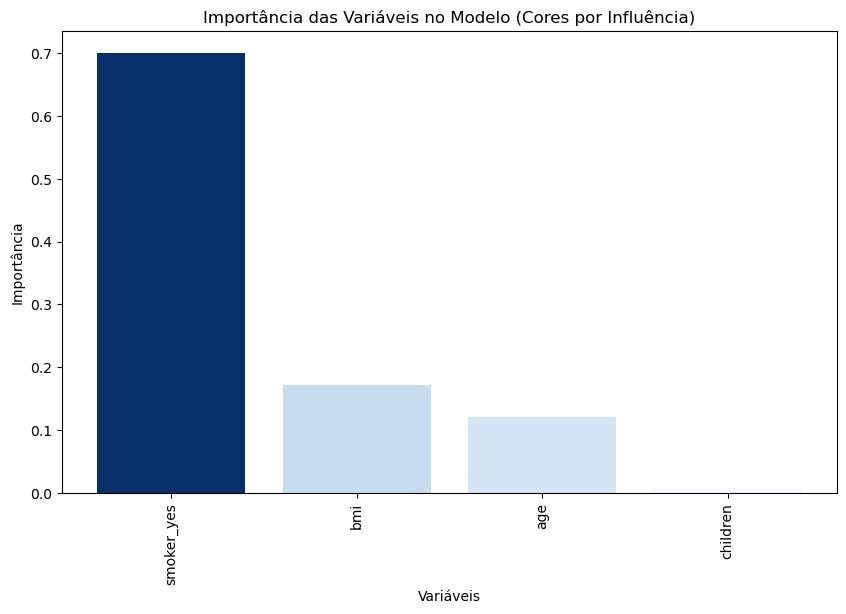

In [9]:


#Criando uma base de dados com os valores de influencia por coluna
colunasQueInfluenciamNaDecisão = {
    "Colunas" : X_train.columns,
    "Influencia" : melhorModelo.feature_importances_
}
colunasQueInfluenciamNaDecisão = pd.DataFrame(colunasQueInfluenciamNaDecisão)
ordenadoPorColunasQueInfluenciamNaDecisão = colunasQueInfluenciamNaDecisão.sort_values(by = "Influencia", ascending=False)


influencias = ordenadoPorColunasQueInfluenciamNaDecisão["Influencia"] / ordenadoPorColunasQueInfluenciamNaDecisão["Influencia"].max()

# Criar um gradiente de cores (quanto maior a importância, mais escura a barra)
colors = plt.cm.Blues(influencias)  # Usando o colormap 'Blues'

# Plotar o gráfico de barras com cores baseadas na importância
plt.figure(figsize=(10, 6))
bars = plt.bar(ordenadoPorColunasQueInfluenciamNaDecisão["Colunas"], ordenadoPorColunasQueInfluenciamNaDecisão["Influencia"] , color=colors)
plt.xticks(range(len(ordenadoPorColunasQueInfluenciamNaDecisão["Colunas"])), ordenadoPorColunasQueInfluenciamNaDecisão["Colunas"].values, rotation=90)
plt.xlabel('Variáveis')
plt.ylabel('Importância')
plt.title('Importância das Variáveis no Modelo (Cores por Influência)')

Com base na análise apresentada no gráfico, observa-se que as variáveis **"smoker_yes"** (indicando se o paciente é fumante) e **"age"** (idade) possuem maior influência nos custos dos seguros médicos. Essas duas variáveis se destacam significativamente em relação às demais, como **"bmi"** (índice de massa corporal) e **"children"** (número de filhos), que apresentam influência muito menor.

Dessa forma, o modelo desenvolvido para prever os gastos médicos dos pacientes identifica **o tabagismo e a idade como os principais fatores determinantes** para os custos. Essas variáveis devem, portanto, ser priorizadas nas análises e recomendações relacionadas à precificação ou políticas de prevenção em saúde.

## Análise com Dados Originais (Validação Complementar)

Para garantir a robustez dos resultados e permitir uma interpretação direta em valores monetários, complementamos nossa análise testando o modelo nos dados originais (sem transformação logarítmica). Esta abordagem visa:

✓ **Traduzir métricas** para valores absolutos (R$) com significado prático imediato  
✓ **Validar a consistência** das relações identificadas (tabagismo e idade como drivers principais)  
✓ **Comparar desempenho** entre abordagens transformadas e não transformadas  

### Metodologia

- **Modelo utilizado**: RandomForestRegressor com os mesmos hiperparâmetros otimizados  
- **Métricas calculadas**:
  - `MAE` (Erro Absoluto Médio em R$)  
  - `RMSE` (Raiz do Erro Quadrático Médio em R$)  
  - `R²` (Coeficiente de Determinação)  



In [12]:
from sklearn.metrics import mean_absolute_percentage_error
def avaliacaoDeEscalaOriginal(y_true_orig, y_pred_orig):

    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    mape = mean_absolute_percentage_error(y_true_orig, y_pred_orig) * 100
    r2 = r2_score(y_true_orig, y_pred_orig)
    rmse =np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    
    print(f"MAE: R$ {mae:.2f} ({mape:.2f}%)")
    print(f"R²: {r2*100:.4f}%")
    print(f"RMSE na escala original: R$ {rmse:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))


avaliacaoDeEscalaOriginal(y_test, y_pred)

MAE: R$ 2467.48 (31.98%)
R²: 87.8367%
RMSE na escala original: R$ 4.345,50


In [ ]:
def avaliacaoDeEscalaOriginal(y_true_log, y_pred_log):
    # Conversão para escala original
    y_true_orig = np.exp(y_true_log)
    y_pred_orig = np.exp(y_pred_log)
    
    # Cálculo das métricas
    metrics = {
        'MAE_R$': mean_absolute_error(y_true_orig, y_pred_orig),
        'MAE_%': mean_absolute_percentage_error(y_true_orig, y_pred_orig) * 100,
        'R2_%': r2_score(y_true_orig, y_pred_orig) * 100,
        'RMSE_R$': np.sqrt(mean_squared_error(y_true_orig, y_pred_orig)),
        'Custo_Médio_R$': np.mean(y_true_orig)
    }
    
    # Cálculo adicional de comparação
    metrics['RMSE_%'] = (metrics['RMSE_R$'] / metrics['Custo_Médio_R$']) * 100
    
    # Formatação de impressão profissional
    print("\n" + "="*60)
    print("AVALIAÇÃO DO MODELO NA ESCALA ORIGINAL (R$)".center(60))
    print("="*60)
    print(f"• MAE (Erro Absoluto Médio):       R$ {metrics['MAE_R$']:,.2f} ({metrics['MAE_%']:.2f}%)".replace(",", "X").replace(".", ",").replace("X", "."))
    print(f"• RMSE (Raiz do Erro Quadrático):  R$ {metrics['RMSE_R$']:,.2f} ({metrics['RMSE_%']:.2f}%)".replace(",", "X").replace(".", ",").replace("X", "."))
    print(f"• R² (Poder Explicativo):          {metrics['R2_%']:.2f}%")
    print(f"• Custo Médio de Referência:       R$ {metrics['Custo_Médio_R$']:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
    print("="*60)

# Exemplo de uso:
avaliacaoDeEscalaOriginal(y_test, y_pred, )


        AVALIAÇÃO DO MODELO NA ESCALA ORIGINAL (R$)         
• MAE (Erro Absoluto Médio):       R$ 1.973,79 (18,05%)
• RMSE (Raiz do Erro Quadrático):  R$ 4.335,85 (33,43%)
• R² (Poder Explicativo):          87.89%
• Custo Médio de Referência:       R$ 12.968,32


### **Análise de Trade-offs no Modelo de Custos Médicos**  

#### **📌 Contexto do Projeto**  
Desenvolvi um modelo de previsão de custos médicos usando **RandomForestRegressor** com uma base de **1.339 registros**. A variável target (`charges`) apresentava **assimetria acentuada**, então apliquei uma **transformação logarítmica** para melhorar a performance do modelo.  

No entanto, mesmo após ajustes, o **RMSE ficou em 33,43% do custo médio**, indicando que alguns valores extremos (outliers) ainda impactavam significativamente as previsões.  

---

### **🔍 Trade-off Enfrentado**  
**"Remover outliers para melhorar as métricas ou mantê-los para preservar casos clinicamente relevantes?"**  

| **Opção**               | **Vantagens**                                     | **Desvantagens**                              |  
|-------------------------|---------------------------------------------------|-----------------------------------------------|  
| **Remover outliers**    | - Melhora MAE/RMSE artificialmente                | - Perde casos raros, porém importantes (ex: pacientes com custos excepcionais) |  
| **Manter outliers**     | - Preserva a integridade dos dados reais          | - Métricas menos otimizadas (RMSE mais alto)  |  

#### **Minha Decisão**  
Optei por **manter os outliers**, pois:  
✅ **Reflete a realidade dos dados**: Custos médicos têm variações extremas (ex: cirurgias complexas vs. consultas simples).  
✅ **Evita viés em casos críticos**: Pacientes com custos altos são justamente os que mais precisam de previsão acurada.  
✅ **Transparência**: Melhor comunicar um RMSE alto, mas realista, do que métricas "infladas" por filtros excessivos.  

---

### **📊 Resultados e Interpretação**  
| **Métrica**       | **Valor**       | **Significado**                                                                 |  
|-------------------|-----------------|---------------------------------------------------------------------------------|  
| **MAE**           | R$ 1.973,79 (18,05%) | Erro médio "aceitável" para o domínio de saúde (valores reais variam muito).    |  
| **RMSE**          | R$ 4.335,85 (33,43%) | Indica a presença de outliers, mas **não invalida** o modelo.                   |  
| **R²**            | **87,89%**      | Excelente poder explicativo, mesmo com a variação natural dos dados.            |  


---

### **🎯 Mensagem Final**  
**"Um bom modelo não é só aquele com as melhores métricas, mas o que melhor atende ao problema real."**  
Neste caso, priorizei **utilidade prática** sobre otimizações numéricas – decisão comum em projetos de saúde, onde dados "imperfeitos" muitas vezes carregam os insights mais valiosos.  
